In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import os
from  tqdm import tqdm 
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [2]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
arr = []
question = []
answer = []
with open("/content/drive/MyDrive/Case_study2_smart_reply/train_data.txt","rb") as json_file:
    data = json.load(json_file)
    for data_ in data['data']:
        for j,para in enumerate(data_['paragraphs']):
          for k,qas in enumerate(para['qas']):
            for ans in qas['answers']:
              answer.append(ans['text'])
              question.append(qas['question'])  
              break

In [5]:
data['data']

In [4]:
question[:5]

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?']

In [5]:
len(answer), len(question)

(86821, 86821)

In [6]:
answer[:5]

['in the late 1990s',
 'singing and dancing',
 '2003',
 'Houston, Texas',
 'late 1990s']

First we will try to load train dataset which is in json format, so we shall extract the 'question' and 'reply' sections from it.

In [7]:
train_df = pd.DataFrame(list(zip(question, answer)), columns =['question', 'reply'])

In [8]:
train_df.head(2)

,question,reply
0,When did Beyonce start becoming popular?,in the late 1990s
1,What areas did Beyonce compete in when she was...,singing and dancing


Loading the QA dataset

In [9]:
qa_df = pd.read_csv(r'/content/drive/MyDrive/Case_study2_smart_reply/qa_dataset.csv', encoding = "ISO-8859-1", low_memory=False)

In [10]:
len(qa_df)

2917

In [11]:
qa_df.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Alessandro_Volta,Was Volta an Italian physicist?,yes,easy,easy,data/set4/a10
1,Alessandro_Volta,Is Volta buried in the city of Pittsburgh?,no,easy,easy,data/set4/a10


Loading the music dataset

In [12]:
music_df = pd.read_csv(r'/content/drive/MyDrive/Case_study2_smart_reply/music_questions.csv', encoding = "ISO-8859-1", low_memory=False)

In [13]:
len(music_df)

2976

In [14]:
music_df.head(2)

,Unnamed: 0,Questions,Answers
0,0,how long is this cord? the pictures looks like...,I took a photo: <http://imgur.com/G48f1C4>I bo...
1,1,Has anyone used this to split a stereo signal?...,I believe this adapter yields a mono split and...


In [15]:
grocery_df = pd.read_csv(r'/content/drive/MyDrive/Case_study2_smart_reply/grocery_questions.csv', encoding = "ISO-8859-1", low_memory=False)

In [16]:
len(grocery_df)

2997

In [17]:
grocery_df.head(2)

,Unnamed: 0,Questions,Answers
0,0,what are the colors that come in the package?,"All colors seen on box plus Teal, Burgundy, Bl..."
1,1,difference between meat cure and pickling salt,Pickling salt is a very pure form of salt. A m...


In [18]:
video_game_df = pd.read_csv(r'/content/drive/MyDrive/Case_study2_smart_reply/video_game_qa.csv', encoding = "ISO-8859-1", low_memory=False)

In [19]:
len(video_game_df)

1183

In [20]:
video_game_df.head(2)

,Unnamed: 0,Questions,Answers
0,0,"Yes, you will need to go to their website to d...","Yes, you will need to go to their website to d..."
1,1,As long as it has a USB port it should work fi...,As long as it has a USB port it should work fi...


We will be keeping only necessary columns i.e., question and reply

In [21]:
qa_df = qa_df.drop(['ArticleTitle','DifficultyFromQuestioner','DifficultyFromAnswerer','ArticleFile'],axis =1 ) 
qa_df.columns = ['question', 'reply']

In [22]:
music_df = music_df.drop(['Unnamed: 0'],axis =1)
music_df.columns = ['question', 'reply']

In [23]:
grocery_df = grocery_df.drop(['Unnamed: 0'],axis =1)
grocery_df.columns = ['question', 'reply']

In [24]:
video_game_df  = video_game_df.drop(['Unnamed: 0'],axis =1)
video_game_df.columns = ['question', 'reply']

We will add all the data frames and make it as 1 dataframe

In [51]:
final_df = [train_df,qa_df,music_df, grocery_df, video_game_df]

In [52]:
final_df = pd.concat(final_df)

In [27]:
final_df.shape

(96894, 2)

Now lets clean some data and do analysis

In [53]:
final_df = final_df.apply(lambda x: x.astype(str).str.lower())
final_df.head(2)

,question,reply
0,when did beyonce start becoming popular?,in the late 1990s
1,what areas did beyonce compete in when she was...,singing and dancing


Removing all special characters from the data and stop words from questions

In [54]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would be removed in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [31]:
final_df.head(3)

,question,reply
0,when did beyonce start becoming popular?,in the late 1990s
1,what areas did beyonce compete in when she was...,singing and dancing
2,when did beyonce leave destiny's child and bec...,2003


In [32]:
from tqdm import tqdm
all_questions= []
for sentence in tqdm(final_df['question'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    all_questions.append(sentence.strip())

100%|██████████| 96894/96894 [00:40<00:00, 2389.64it/s]


In [55]:
final_df['question'] =  all_questions

We have 296 duplicate values in our dataset, we will not be dropping those as it will be helpful in getting multiple replies.

In [37]:
#https://www.geeksforgeeks.org/find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns/
final_df[final_df.duplicated(keep = 'last')]

,question,reply
251,when did beyonce have her first child,"january 7, 2012"
786,in what year did chopin become a french citizen,1835
916,what year did chopin leave warsaw,1830
1061,what was the name of liszt s mistress,marie d'agoult
1286,how long was chopin s funeral delayed,two weeks
...,...,...
1085,yes,yes
1102,yes,yes
1108,yes,yes
1133,yes,yes


In [34]:
all_replies= []
for sentence in tqdm(final_df['reply'].values): 
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)   
    all_replies.append(sentence.strip())

100%|██████████| 96894/96894 [00:01<00:00, 71244.58it/s]


We can get the length of all the question and replies.

In [ ]:
len_str_arr = []
for sentence in final_df["reply"].values:
  len_str_arr.append(len(sentence.split()))
final_df["reply_length"]= len_str_arr

final_df = final_df[(final_df.reply_length < 8)]
print(final_df.head())

len_str_arr_quest = []
for sentence in final_df["question"].values:
  len_str_arr_quest.append(len(sentence.split()))

final_df['question_length'] = len_str_arr_quest 
final_df = final_df[final_df.question_length < 100]

In [43]:
print(final_df.size)

333932


In [59]:
final_df.head(2)

,question,reply,reply_length,question_length
0,when did beyonce start becoming popular,in the late 1990s,4,6
1,what areas did beyonce compete in when she was...,singing and dancing,3,11


Lets consider only those rows which has reply_length more than zero.

In [61]:
final_df = final_df[final_df['reply_length']>0]

We can check how many times a reply is repeated as the replies which are most repeated will help us in suggesting better.

In [62]:
final_df[final_df.duplicated('reply')]

,question,reply,reply_length,question_length
8,when did beyonc rise to fame,late 1990s,2,6
10,what was the first album beyonc released as a ...,dangerously in love,3,11
11,when did beyonc release dangerously in love,2003,1,7
13,what was beyonc s role in destiny s child,lead singer,2,9
14,what was the name of beyonc s first solo album,dangerously in love,3,10
...,...,...,...,...
1133,yes,yes,1,1
1147,no,no,1,1
1157,yes,yes,1,1
1167,yes,yes,1,1


In [63]:
# Python3 program to find number of 
# times a string appears in an array. 

repeated_count = []
# Returns count of occurrences of s in arr[] 
def search(arr, s): 
	counter = 0
	for j in (range(len(arr))): 
		
		# checking if string given in query 
		# is present in the given string. 
		# If present, increase times 
		if (s == (arr[j])): 
			counter += 1

	return counter 

def answerQueries(arr, q): 
	for i in tqdm(range(len(q))): 
		repeated_count.append(search(arr, q[i]))

# Driver code /
if __name__ == '__main__': 
	arr = final_df['reply'].values 
	q = final_df['reply'].values 
	answerQueries(arr, q) 

# This code is contributed 
# by PrinciRaj19992 from github


100%|██████████| 83483/83483 [19:37<00:00, 70.87it/s]


In [64]:
count = 0
for item in repeated_count:
  if item > 0:
    count += 1

print("total replies, repeated as well as not repeated ",count)

count = 0
for item in repeated_count:
  if item > 1:
    count += 1

print("total replies more than 1",count)

count = 0
for item in repeated_count:
  if item > 2:
    count += 1

print("total replies more than 2",count)

count = 0
for item in repeated_count:
  if item > 3:
    count += 1

print("total replies more than 3",count)

count = 0
for item in repeated_count:
  if item > 4:
    count += 1

print("total replies more than 4",count)

count = 0
for item in repeated_count:
  if item > 5:
    count += 1

print("total replies more than 5",count)

count = 0
for item in repeated_count:
  if item > 6:
    count += 1

print("total replies more than 6",count)


count = 0
for item in repeated_count:
  if item > 7:
    count += 1

print("total replies more than 7",count)

count = 0
for item in repeated_count:
  if item > 11:
    count += 1

print("total replies more than 11",count)

count = 0
for item in repeated_count:
  if item > 15:
    count += 1

print("total replies more than 15",count)


count = 0
for item in repeated_count:
  if item > 16:
    count += 1

print("total replies more than 16",count)



count = 0
for item in repeated_count:
  if item > 17:
    count += 1

print("total replies more than 17",count)



count = 0
for item in repeated_count:
  if item > 18:
    count += 1

print("total replies more than 18",count)



count = 0
for item in repeated_count:
  if item > 19:
    count += 1

print("total replies more than 19",count)

count = 0
for item in repeated_count:
  if item > 20:
    count += 1
print("total replies more than 20",count)

count = 0
for item in repeated_count:
  if item > 21:
    count += 1
print("total replies more than 21",count)    

count = 0
for item in repeated_count:
  if item > 22:
    count += 1
print("total replies more than 22",count)

count = 0
for item in repeated_count:
  if item > 23:
    count += 1

print("total replies more than 23",count)

total replies, repeated as well as not repeated  83483
total replies more than 1 32629
total replies more than 2 23109
total replies more than 3 19047
total replies more than 4 16723
total replies more than 5 15103
total replies more than 6 13861
total replies more than 7 13028
total replies more than 11 10350
total replies more than 15 8736
total replies more than 16 8464
total replies more than 17 8175
total replies more than 18 7797
total replies more than 19 7455
total replies more than 20 7175
total replies more than 21 6965
total replies more than 22 6789
total replies more than 23 6559


In [65]:
final_df['repeated_reply_count'] = repeated_count

Lets consider replies with more than 20 count.

In [66]:
final_df_new = final_df[final_df.repeated_reply_count > 20]

In [67]:
final_df_new.shape

(7175, 5)

Checking number of unique replies in the data

In [68]:
unique_replies = (final_df_new.reply.unique())

In [69]:
total_unique_replies = len(unique_replies)
total_unique_replies

155

Let see which are top repeated replies:

In [70]:
reply_list = list(final_df_new['reply'].values)
reply_dict = {i:reply_list.count(i) for i in reply_list}

In [71]:
from collections import OrderedDict
reply_dict_sorted = OrderedDict(sorted(reply_dict.items(), key=lambda x: x[1]))

In [72]:
reply = []
keys = []
for item in reply_dict_sorted.items():
  reply.append(item[0])
  keys.append(item[1])

In [73]:
reply.reverse()
keys.reverse()

In [74]:
#top 15 reply
top_15_reply = reply[:15]
top_15_keys = keys[:15]

In [75]:
temp_reply_list = []
i = 0
for key in top_15_keys:
  for _ in range(0,key):
    temp_reply_list.append(top_15_reply[i])
  i += 1

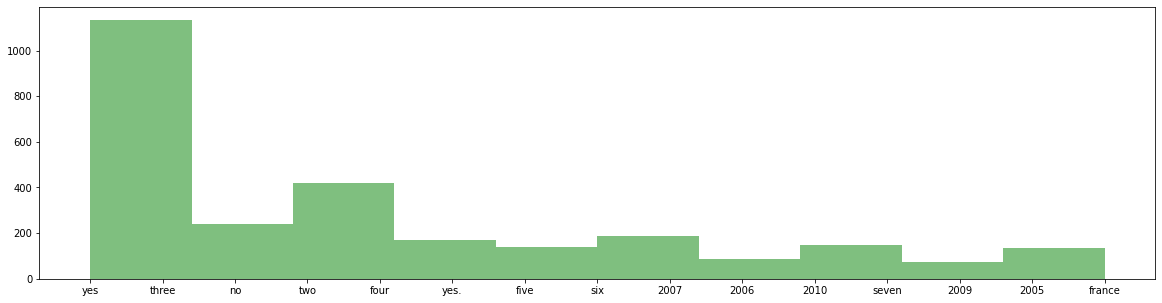

In [76]:
import matplotlib
matplotlib.rc('figure', figsize=[20,5])
plt.hist(temp_reply_list, 10,
         histtype='bar',
         facecolor='g',
         alpha=0.5)
plt.show()

Now lets see the average length of the replies:

number of email don' have any reply : 0
**************************************************
Max length : 3
**************************************************
Min Length : 1
**************************************************
Average Length : 1.0416724738675958
**************************************************
unique replies in the data 155
--------------------------------------------------
Distribution of the words
--------------------------------------------------


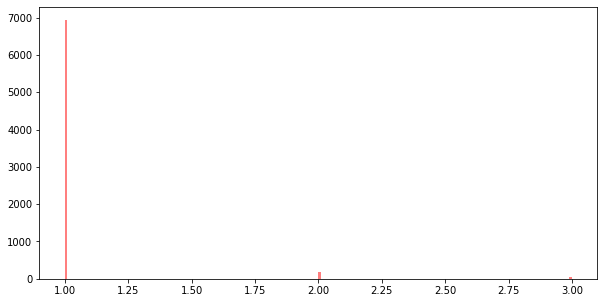

In [78]:
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
#Getting the length of each Answer
len_answers = final_df_new["reply"].values
#len_answers = data["reply_length"].values

#converting datatype to string
len_str_arr = []
for sentence in len_answers:
  len_str_arr.append(len(sentence.split()))


temp_arr = []
for indx in len_answers:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)

no_reply_counter = 0 
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_str_arr)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(len_str_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_str_arr)))/(len(list(len_str_arr))))
print('*' * 50)


# need to get all the unique replies in the dataset
all_unique_replies = list(set(final_df_new['reply'].values))
print('unique replies in the data',len(all_unique_replies))


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

len_str_arr.sort()
plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

In [81]:
all_questions = final_df_new['question'].values

In [82]:
#Preprocessing Questions 
#Remove the full stops from the dataframe answers

bad_chars = [';', ':', '!', "*",'.',')','(','?']

preprocessed_question = []
for question in all_questions:
  for i in bad_chars : 
    question = question.replace(i, '')
  preprocessed_question.append(question)

Words stemming:

In [83]:
#https://www.geeksforgeeks.org/introduction-to-stemming/
#Performing stammering here
# We are having less data
from nltk.stem import PorterStemmer
porter = PorterStemmer()
stemmed_sent = []
for sent in preprocessed_question:
  word_arr = []
  for word in sent.split():
    word_arr.append(porter.stem(word))
  temp_str = ""
  for words in word_arr:
    temp_str += words + " "
  stemmed_sent.append(temp_str)

final_df_new['question'] = stemmed_sent  

<ipython-input-83-86bb93611d50>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_new['question'] = stemmed_sent


In [84]:
#trimming the string the dataframe  
#because after removal of the special character we might have lost the trimming
final_df_new = final_df_new.applymap(lambda x: x.strip() if isinstance(x, str) else x)

number of email don' have any reply : 1
**************************************************
Max length : 229
**************************************************
Min Length : 2
**************************************************
Average Length : 52.31581881533101
**************************************************
No of unique questions : 152
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


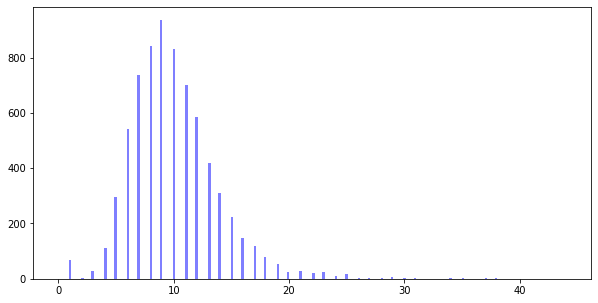

In [86]:
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
#Getting the length of each Answer
len_questions = final_df_new["question"].str.len()

#converting datatype to string

len_str_arr = []
for data_ in final_df_new["question"].values:
  len_str_arr.append(len(data_.split()))


no_reply_counter = 0
for num in len_questions:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_questions:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_questions)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_questions)))/(len(list(len_questions))))
print('*' * 50)

print("No of unique questions", end = ' : ')
print(len(list(set(len_questions))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)
len_str_arr.sort()
plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

As we can see that number of maximum numner of words in questions have 5 words
and most of them are in range 3-10